#  Summer Research \# 2
## Finite differences for Polar, Cylindrical, and Spherical Geometries

#### Executive Summary
** Insert Executive Summary Here **

### Linear Advection Equation in Polar

We have already seen the two dimensional advection equation in Cartesian coordinates, written as

\begin{align}
\frac{\partial}{\partial t} u(x,y; t) + c_1\frac{\partial}{\partial x} u(x,y; t) + c_2 \frac{\partial}{\partial y} u(x,y; t) &= 0
\end{align}

However, we could also think of this as 
\begin{align}
\frac{\partial}{\partial t} u(x,y; t) + c \nabla u &= 0,
\end{align}

which will allow us to easily interpret the gradient of the function $u$ in polar, cylindrical, and spherical coordinates. Starting with polar, we have

\begin{align}
\frac{\partial}{\partial t} u(r,\theta; t) + c\left(\frac{\partial}{\partial r} u(r,\theta; t) + \frac{1}{r} \frac{\partial}{\partial \theta} u(r,\theta; t)\right)  &= 0,
\end{align}

Now we can discretize it using forward difference approximation,
\begin{align}
\frac{u_{ij}^{n+1} - u_{ij}^{n}}{\Delta t} + c\frac{u_{i+1j}^n - u_{ij}^n}{\Delta r} + \frac{c}{r}\frac{u_{ij+1}^n - u_{ij}^n}{\Delta \theta} &=0\\
u_{ij}^{n+1} &= u_{ij}^n - \frac{c\Delta t}{\Delta r}\left(u_{i+1j}^n - u_{ij}^n\right) - \frac{c\Delta t}{r\Delta\theta}\left(u_{ij+1}^n - u_{ij}^n\right)
\end{align}

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg as spla
from scipy.sparse import dia_array
from scipy.sparse.linalg import gmres
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [3]:
np.random.seed(12345)

In [4]:
def tridiag(a,b,c,n,*, is_sparse: bool = False):
    # Make a tridiagonal matrix, which is common in FDM
    
    if is_sparse == False:
        # Create an n x n tridiagonal matrix with subdiagonal a, diagonal b, and superdiagonal c
        A = np.diag(a * np.ones(n-1), -1) + np.diag(b * np.ones(n)) + np.diag(c * np.ones(n-1), 1)
    else:
        # An Attempt to make a sparse matrix structure. 
        ## Need to test
        ex = np.ones(n)
        data = np.array([a * ex, b * ex, c * ex])
        offsets = np.array([-1, 0, 1])
        A = dia_array((data, offsets), shape=(n, n))
        
        
    return A
    

In [9]:
def fd3df(nw, nr, nz, alpw = 0, alpr = 0, alpz = 0, cw = 1., cr = 1., cz = 1.,  dshift = 0, *, is_sparse: bool = False): 
    # First order Forward Method

    if is_sparse == False:
        # Create tridiagonal matrices tx, ty, and tz
        firstcol = np.zeros(nw)
        firstcol[0], firstcol[-1] = -1,1
        tw = cw * sp.linalg.circulant(firstcol) #theta component
        # tw = cw * tridiag(0, -1, 1, nw) # Slower implimentation
        tr = cr * tridiag(0, -1, 1, nr) # radial component
        tz = cz * tridiag(0, -1, 1, nz) # z - component

        A = tw
        if nr > 1:
            A = np.kron(np.eye(nr), A) + np.kron(tr,np.eye(nw))
            if nz > 1:
                A = np.kron(np.eye(nz), A) + np.kron(tz,np.eye(nw * nr))
    
        A -= dshift * np.eye(nw * nr * nz)
    else:
        # Create tridiagonal matrices tx, ty, and tz
        tx = tridiag(0, -1, 1, nx, is_sparse = True)
        ty = tridiag(0, -1, 1, ny, is_sparse = True)
        tz = tridiag(0, -1, 1, nz, is_sparse = True)

        # Create sparse kroneckers
        A = tx
        if ny > 1:
            A = sp.sparse.kron(sp.sparse.identity(ny),A) + sp.sparse.kron(ty,sp.sparse.identity(nx))
            if nz > 1:
                A = sp.sparse.kron(sp.sparse.identity(nz),A) + sp.sparse.kron(tz,sp.sparse.identity(nx * ny))

        A -= dshift * sp.sparse.identity(nx * ny * nz)
    return A
    

In [10]:
A = fd3df(4,2,2, cw = 1, cr = 1)

print(A)

[[-3.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -3.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -3.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0. -3.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -3.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -3.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -3.  1.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0. -3.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -3.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -3.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -3.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. -3.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -3.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -3.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -3. 

In [11]:
def fd3dc(nw, nr, nz, alpw = 0, alpr = 0, alpz = 0, cw = 1., cr = 1., cz = 1., dshift = 0, *, is_sparse: bool = False):
    # First order Forward Method

    if is_sparse == False:
        # Create tridiagonal matrices tx, ty, and tz
        tw = cw * tridiag(-0.5, 0, 0.5, nw)
        # If there is enough gridpoints, we use a second order forward method for the left point,
        # and second order backward method for the right point. Now all O(h^2)
        #if nx > 2:
            #tx[0, :3] = np.array([-1.5,2,-0.5])
            #tx[nx-1,-3:] = np.array([0.5,-2,1.5])
        tw[-1,0], tw[0,-1] = 0.5, -0.5
        A = tw
        if nr > 1:
            tr = cr * tridiag(-0.5, 0, 0.5, nr)
            #if ny > 2:
                #ty[0, :3] = np.array([-1.5,2,-0.5])
                #ty[ny-1,-3:] = np.array([0.5,-2,1.5])
            A = np.kron(np.eye(nr), A) + np.kron(tr,np.eye(nw))
            if nz > 1:
                tz = cz * tridiag(-0.5, 0, 0.5, nz)
                if nz > 2:
                    #tz[0, 0:3] = np.array([-1.5,2,-0.5])
                    #tz[nz-1,-3:] = np.array([0.5,-2,1.5])
                    A = np.kron(np.eye(nz), A) + np.kron(tz,np.eye(nw * nr))
    
        A -= dshift * np.eye(nw * nr * nz)
    else:
        # Create tridiagonal matrices tx, ty, and tz
        tx = tridiag(0, -1, 1, nx, is_sparse = True)
        ty = tridiag(0, -1, 1, ny, is_sparse = True)
        tz = tridiag(0, -1, 1, nz, is_sparse = True)

        # Create sparse kroneckers
        A = tx
        if ny > 1:
            A = sp.sparse.kron(sp.sparse.identity(ny),A) + sp.sparse.kron(ty,sp.sparse.identity(nx))
            if nz > 1:
                A = sp.sparse.kron(sp.sparse.identity(nz),A) + sp.sparse.kron(tz,sp.sparse.identity(nx * ny))

        A -= dshift * sp.sparse.identity(nx * ny * nz)
    return A

In [12]:
%%timeit
A = fd3df(1500,1,1)


#plt.spy(A)
#plt.show()

3.46 ms ± 31.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


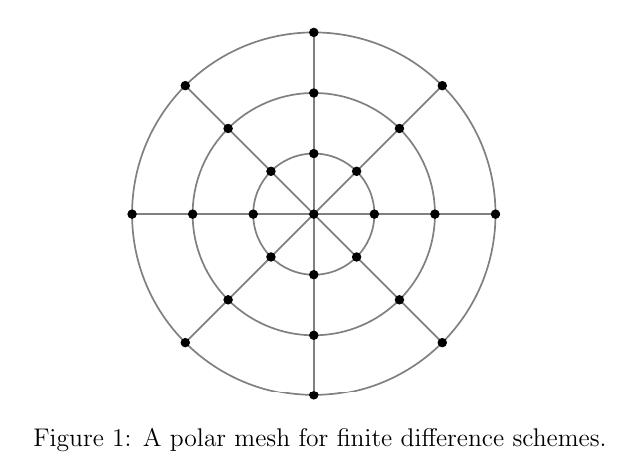

First it might be helpful to see what the forward and centered difference scheme looks like for the grid above.

The node $u_{ij}$ is the solution at $(i\Delta r, j\Delta \theta)$, where $i\in[0,R], j\in[0,2\pi/\Delta \theta)$. Since there is a periodic requirement, we are able to reuse the forward difference scheme code with a slight modification that there is now a 1 in the bottom left entry. 

This means we get the following structure:
\begin{align}
\mathbf{L}_f &:= \frac{1}{\Delta r}\begin{pmatrix}
\mathbf{B}_f & \mathbf{I} & \mathbf{0} &\cdots & \mathbf{0}\\
\mathbf{0} & \mathbf{B}_f & \mathbf{I} & \cdots & \mathbf{0}\\
\vdots  & \ddots & \ddots & \ddots & \vdots\\
\mathbf{0} & \cdots & \mathbf{0} &\mathbf{0} & \mathbf{B}_f
\end{pmatrix}\\
\mathbf{B}_f &:= \begin{pmatrix}
-1 & 1 & 0 &\cdots & 0\\
0 & -1 & 1 & \cdots & 0\\
\vdots  & \ddots & \ddots & \ddots & \vdots\\
1 & \cdots & 0 & 0 & -1
\end{pmatrix}
\end{align}

For the centered difference, we see a similar structure:
\begin{align}
\mathbf{L}_c &:= \frac{1}{\Delta r}\begin{pmatrix}
\mathbf{B}_c & \mathbf{I} & \mathbf{0} &\cdots & \mathbf{0}\\
-\mathbf{I} & \mathbf{B}_c & \mathbf{I} & \cdots & \mathbf{0}\\
\vdots  & \ddots & \ddots & \ddots & \vdots\\
\mathbf{0} & \cdots & \mathbf{0} & -\mathbf{I} & \mathbf{B}_c
\end{pmatrix}\\
\mathbf{B}_c &:= \begin{pmatrix}
0 & 1 & 0 &\cdots & -1\\
-1 & 0 & 1 & \cdots & 0\\
\vdots  & \ddots & \ddots & \ddots & \vdots\\
1 & \cdots & 0 & -1 & 0
\end{pmatrix}
\end{align}

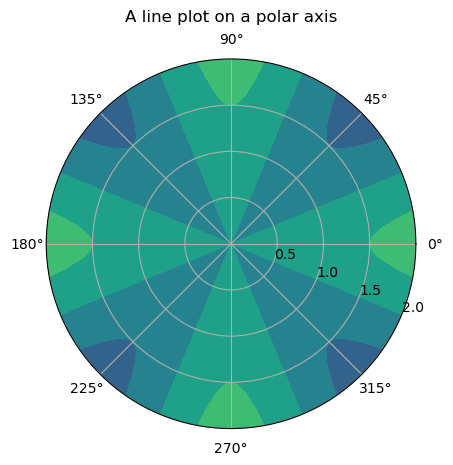

In [82]:
r = np.linspace(0,5,101)
theta = np.linspace(0,2*np.pi, 129)
f = lambda r, theta: r * np.cos(4*theta)

r, theta = np.meshgrid(r, theta)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.contourf(theta, r, f(r,theta))
ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()


In [38]:
def cart2pol(x, y, z = 1):

    r = np.sqrt((x * x) + (y * y))
    theta = np.arctan2(y,x)
    if z != 1:
        return z 
    return r, theta

In [40]:
def pol2cart(r, theta, z=1):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    if z != 1:
        return z
    return x, y

In [42]:
def cart2sph(x, y, z):
    r = np.sqrt((x*x) + (y*y) + (z*z))
    theta = np.sign(y) * np.arccos( x / (np.sqrt((x*x) + (y*y))))
    phi = np.arccos(z/r)
    
    return r, theta, phi

In [44]:
def sph2cart(r, theta, phi):
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)

    return x, y, z

In [58]:
class fd3dGridC:
    """
    a finite-difference grid
    """

    def __init__(self, nr, nw, nz = 1, ng = 1, rmax=1.0, zmax = 1.0):
        """
        create a 2D grid with (nx + 1) points that runs from [xmin, xmax].
        Additionally calculates dx and the x values where the solution is computed.
        """

        self.rmin = 0.0
        self.rmax = rmax

        self.zmin = 0.0
        self.zmax = zmax
        
        self.ng = ng
        self.nr = nr
        self.nw = nw
        self.nz = nz

        self.ilo = ng
        self.ihi = ng+nr-1

        # physical coords
        self.dr = rmax / nr
        self.rpts = np.linspace(0, rmax, num = nr + 1)

        self.dw = 2* np.pi / nw
        self.wpts = np.linspace(0, 2*np.pi, num = nw +1)

        self.dz = zmax / nz
        self.zpnts = np.linspace(0, zmax, num = nz + 1)

    def fill_BCs(self):
        """ fill the a single ghostcell with periodic boundary conditions """
        self.a[self.ilo-1] = self.a[self.ihi-1]
        self.a[self.ihi+1] = self.a[self.ilo+1]

        # storage for the solution
        # self.sol = np.zeros(nx + 1, dtype=np.float64)
        
        
    #def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
    #    return np.zeros((self.nx+2*self.ng), dtype=np.float64)

In [59]:
class advectionPDE:
    """
    a way to store all of the information of the PDE
    """
    
    def __init__(self, init_cond, bndy_cond, bndy_type, dim = 1, a = 1., source = 0):
        self.a = a
        self.init_cond = init_cond
        self.bndy_type = bndy_type
        if a > 0:
            self.bndy_cond = bndy_cond
        self.dim = dim
        self.source = source # homogenous if f := 0

In [60]:
class solution:

    def __init__(self, coord1, coord2, coord3 = 0):
        self.coord1 = coord1
        self.coord2 = coord2
        if coord3 != 0:
            self.coord3 = coord3

In [63]:
def advec_FE_2DP(grid, pde):
    
    # Grid Params
    nr = grid.nr
    nw = grid.nw
    #nz = grid.nz
    
    dr = grid.dr
    dw = grid.dw
    #dz = grid.dz
    
    rpts = grid.rpts
    wpts = grid.wpts
    #zpts = grid.zpts
    
    # PDE Params
    a = pde.a 
    source = pde.source
    bc = pde.bndy_type

    # Time Params
    # In Time class coming soon
    t0 = 0.0
    tf = grid.rmax / a
    C = 0.49
    dt = C * grid.dr / a
    tpts = np.arange(t0, tf, dt )
    maxk = len(tpts) - 1
    
    # if C >= 0.5:
    #    raise CourantConstantError('C is too high! For Euler's C<0.5.')

    
    # Initial condition function
    # f = lambda x: np.sin(x)
    f = pde.init_cond
    
    # Boundary Values
    # a = lambda x: np.exp(x) 
    # b = lambda x: np.exp(x) * np.sin(1)
    al = pde.bndy_cond
    if bc == 'Neumann':
        mu = al
        nu = ar
        al = lambda x : 0
        ar = al
        bc = 'Robin'
        print('Successsss.')

    # Solution and applying IC, BCs
    u = np.zeros(((nw*(nr + 1) +1), maxk + 1), dtype = float)
    u[:,0] = f(rpts)
    u[-nw:,:] = al(tpts)
    

    if bc == 'Dirichlet':
        # Constructing (I + cL) where L is the difference operator with bc
        IpcL = np.zeros((nw*(nr+1)+1,nw*(nr+1)+1)) 
        IpcL[1:nw*nr+1, 1:nw*nr+1] = 1 * fd3df(nw,nr ,1) # Typical 1,2,1 stencil scaled by C with identity shift, i.e. (I + cL).
        IpcL[0,:nw+1] = 4 * np.ones(nw + 1) # Points at r = 0
        #IpcL[1:nw+1, 0] = -1* np.ones(nw)
        IpcL[0,0] *= -nw
        IpcL[-nw:,-nw:] = 0 # Boundary points
        IpcL += np.eye(nw*(nr+1)+1)

        for k in range(maxk):
            # Applying the difference operator to the solution, then applying BCs
            u[:,k+1] =  np.dot(IpcL, u[:,k]) #+ dt * source(xpts,tpts[k])
            u[0,k+1] = al(tpts[k+1])
    elif bc == 'Robin':
        L = fd3df(n+1,1,1)
        for k in range(maxk):
            # Constructing the difference operator with bc. 
            L[0,0:2] = np.array([-2 * (1 + dx * a(tpts[k])), 2])
            L[n,n-2:n] = np.array([2, -2 * (1 + dx * b(tpts[k]))])
            
            # Difference operator update through time
            IpcL = np.eye(n+1) + C * L
            u[:,k+1] =  np.dot(IpcL, u[:,k]) + dt * source(xpts,tpts[k+1])
            
            # Applying BC for Neumann term
            u[0,k+1] = -2* (dt / dx) * mu(tpts[k])
            u[n,k+1] = -2* (dt / dx) * nu(tpts[k])
    else: # Periodic
        print('Need to do this still')
    
        
    
    return rpts, wpnts, u

In [64]:
pde = advectionPDE(lambda r: 100, lambda t: 0, bndy_type = 'Dirichlet', dim = 1)
grid = fd3dGridC(2,4)

rpnts, wpnts, u = advec_FE_2DP(grid, pde)

NameError: name 'wpnts' is not defined

2D heat equation solver


MovieWriter ffmpeg unavailable; using Pillow instead.


Done!


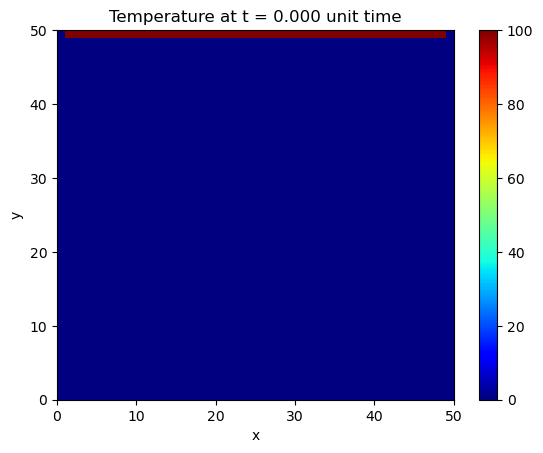

In [61]:
print("2D heat equation solver")

plate_length = 50
max_iter_time = 750

alpha = 2
delta_x = 1

delta_t = (delta_x ** 2)/(4 * alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)

# Initialize solution: the grid of u(k, i, j)
u = np.empty((max_iter_time, plate_length, plate_length))

# Initial condition everywhere inside the grid
u_initial = 0

# Boundary conditions
u_top = 100.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0

# Set the initial condition
u.fill(u_initial)

# Set the boundary conditions
u[:, (plate_length-1):, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (plate_length-1):] = u_right
def calculate(u):
    for k in range(0, max_iter_time-1, 1):
        for i in range(1, plate_length-1, delta_x):
            for j in range(1, plate_length-1, delta_x):
                u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]

    return u

def plotheatmap(u_k, k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Temperature at t = {k*delta_t:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=100)
    plt.colorbar()

    return plt

# Do the calculation here
u = calculate(u)

def animate(k):
    plotheatmap(u[k], k)

anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=True)
anim.save("heat_equation_solution.gif")

print("Done!")

MovieWriter ffmpeg unavailable; using Pillow instead.


Done!


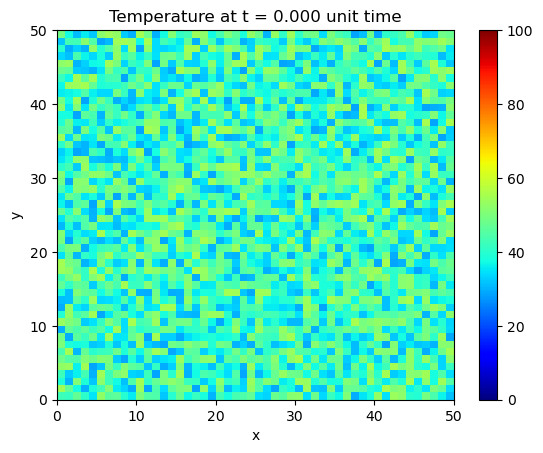

In [62]:
# Change boundary conditions
u_top = 0.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0

# Change u_initial (random temperature between 28.5 and 55.5 degree)
#u_initial = 0
u_initial = np.random.uniform(low=28.5, high=55.5, size=(plate_length,plate_length))

# Change initial conditions
#u.fill(u_initial)
u[0,:,:] = u_initial


anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=True)
anim.save("heat_equation_solution2.gif")

print("Done!")

What to do at $r=0$?

Let's assume that we have an axi-symmetric diffusion (reasonable assumption). 
\begin{align}
u_t &= \frac{1}{r} \frac{\partial}{\partial r}\left(r\alpha(r,z)u_r\right) + \frac{\partial}{\partial z} \left(\alpha(r,z) u_z\right) + f(r,z,t)
\end{align}

but notice that $u_r(0,t) = 0$ which is a necessary symmetry condition. By the product rule, we have 
\begin{align}
u_t &= \frac{1}{r}\frac{\partial}{\partial r}\left(r\alpha(r)u_r\right) + f(t)\\
&= \frac{1}{r}r\alpha(r)u_{rr} + \frac{1}{r}r\alpha'(r)u_r + \frac{1}{r}\alpha(r)u_r \\
&= \alpha(0)u_{rr} + 0 + \frac{1}{r}u_r
\end{align}

which results in a L'hopital computations resulting from $r=0$ and $u_r(0,t) = 0$, so $\lim_{r\to0} \frac{1}{r}u_r = u_{rr}$. This means at $r=0$. we have $2\alpha(0,t)u_{rr}$, which we can approximate by
\begin{align}
2\alpha(0)u_{rr} &\approx 2\alpha(0)\frac{u_{-1} -2u_0 + u_1}{\left(\Delta r\right)^2}\\
&= 4\alpha(0)\frac{u_1-u_0}{\left(\Delta r\right)^2},
\end{align}

since we need to enforce the radial symmetry.
